# Multiclass_ImageGenerator

This notebook uses the ImageDataGenerator and flow_from_generator method to create the images rather than using manually preprocessed images

In [27]:
# Import and Magic!
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn import metrics
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils, to_categorical, Sequence
from keras.preprocessing.image import ImageDataGenerator

#magic
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [28]:
height=width=28

In [29]:
# Create the ImageDataGenerator object.
datagen = ImageDataGenerator(rotation_range = 30,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   rescale=1./255,
                                   validation_split=.25)
                                   

# Create the training data from the generator object
train_imagegen = datagen.flow_from_directory(directory='../../images/train/',
                                                    target_size=(height, width),
                                                    color_mode="grayscale",
                                                    batch_size=32,
                                                    shuffle=True,
                                                    save_format = 'png',
                                                    class_mode="categorical",
                                                    subset='training')

# Create the validation/testing data from the generator object
val_imagegen = datagen.flow_from_directory(directory='../../images/train/',
                                                    target_size=(height, width),
                                                    color_mode="grayscale",
                                                    batch_size=32,
                                                    shuffle=True,
                                                    save_format = 'png',
                                                    class_mode="categorical",
                                                    subset='validation')

Found 389377 images belonging to 11 classes.
Found 129787 images belonging to 11 classes.


In [30]:
# This bit of code allows keras/tf to dynamically grow the GPU memory. This may or may not be solving the GPU
# issue I was having. Taken from https://www.cicoria.com/keras-tensor-flow-cublas_status_not_initialized/

from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
                                    # (nothing gets printed in Jupyter, only if you run it standalone)
sess = tf.Session(config=config)
set_session(sess)  # set this TensorFlow session as the default session for Keras

In [31]:
# Instantiate
cnn_model = Sequential()

#Input Layer
cnn_model.add(Conv2D(filters=112, kernel_size=(3,3), activation='relu',input_shape = (height, width,1)))
cnn_model.add(MaxPooling2D(pool_size=2))
cnn_model.add(Dropout(0.5))

# Second Layer
cnn_model.add(Conv2D(56, kernel_size=3,activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=2))
cnn_model.add(Dropout(0.5))


# Third Layer
cnn_model.add(Conv2D(28, kernel_size=2,activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=2))
cnn_model.add(Dropout(0.3))

# Fourth Layer
cnn_model.add(Conv2D(14, kernel_size=2,activation='relu'))
# cnn_model.add(MaxPooling2D(pool_size=2))
cnn_model.add(Dropout(0.5))

# Flatten
cnn_model.add(Flatten())

# Fifth Layer
cnn_model.add(Dense(112, activation='relu'))

# Sixth Layer
cnn_model.add(Dense(56, activation='relu'))

# Seventh Layer
cnn_model.add(Dense(28, activation='relu'))

# Output Layer
cnn_model.add(Dense(11, activation='softmax'))

# Compile
cnn_model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

# Summary of the model
cnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 26, 26, 112)       1120      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 13, 13, 112)       0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 13, 13, 112)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 11, 11, 56)        56504     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 5, 5, 56)          0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 5, 5, 56)          0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 4, 4, 28)          6300      
__________

In [32]:
# Fit the model, saving off the result to a history object for use later
history = cnn_model.fit_generator(
    train_imagegen,
    steps_per_epoch=500,
    epochs=10,
    verbose=1,
    validation_data=val_imagegen,
    validation_steps=100) 

Epoch 1/10
500/500 [==============================] - 323s 645ms/step - loss: 1.3795 - acc: 0.5039 - val_loss: 1.1007 - val_acc: 0.7159
Epoch 2/10
500/500 [==============================] - 320s 640ms/step - loss: 1.0154 - acc: 0.7199 - val_loss: 1.0443 - val_acc: 0.7419
Epoch 3/10
500/500 [==============================] - 319s 638ms/step - loss: 0.9692 - acc: 0.7339 - val_loss: 1.0372 - val_acc: 0.7450
Epoch 4/10
500/500 [==============================] - 316s 632ms/step - loss: 0.9367 - acc: 0.7402 - val_loss: 0.9788 - val_acc: 0.7525
Epoch 5/10
500/500 [==============================] - 319s 639ms/step - loss: 0.9351 - acc: 0.7425 - val_loss: 1.1813 - val_acc: 0.6000
Epoch 6/10
500/500 [==============================] - 317s 635ms/step - loss: 0.9200 - acc: 0.7475 - val_loss: 1.2337 - val_acc: 0.5169
Epoch 7/10
500/500 [==============================] - 315s 631ms/step - loss: 0.9245 - acc: 0.7471 - val_loss: 1.1082 - val_acc: 0.6659
Epoch 8/10
500/500 [============================

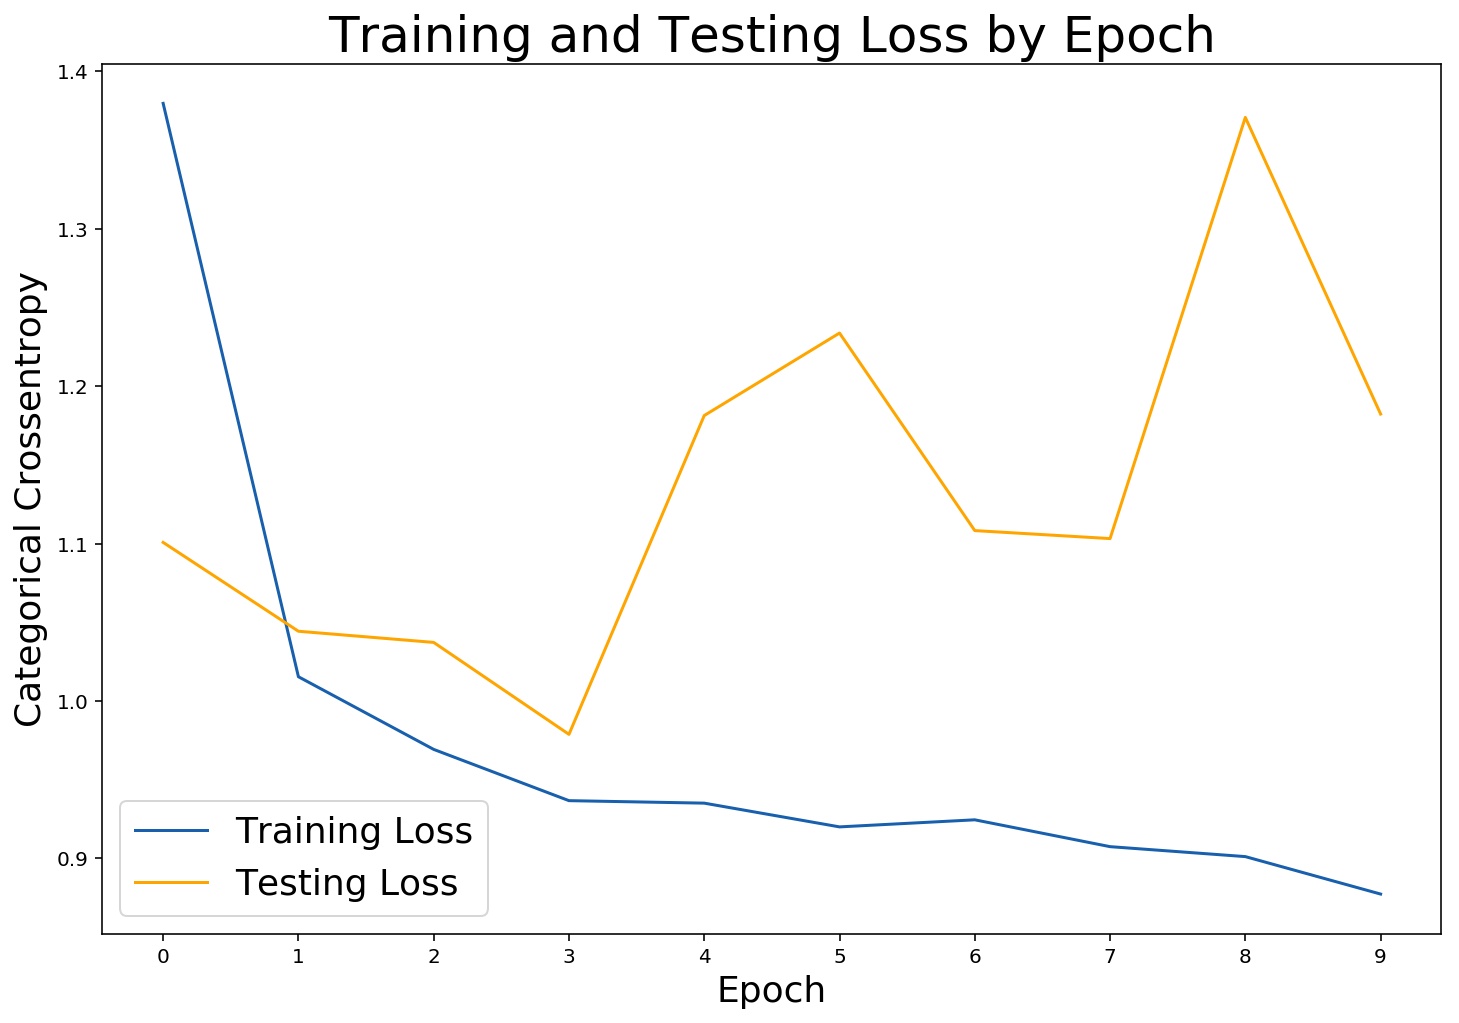

In [33]:
# Check out our train loss and test loss over epochs.
train_loss = history.history['loss']
test_loss = history.history['val_loss']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(test_loss, label='Testing Loss', color='orange')

# Set title
plt.title('Training and Testing Loss by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)
plt.xticks(range(10))

plt.legend(fontsize = 18);
plt.savefig('../../graphs/imggenx28.png')

In [34]:
# Get the number of steps to use. This is the length of the validation array divided by the
# batch_size.
# I don't know why, but this is necessary to get an array of predictions the same size 
# as the ground truth
num_steps = len(val_imagegen.classes) / 32
num_steps

4055.84375

In [35]:
# Get true values from the image generator
y_test = val_imagegen.classes

# Get predictions
predictions = cnn_model.predict_generator(val_imagegen, steps=num_steps)

In [36]:
# Double check that both arrays are the same size to allow comparison and confusion matrices
print(len(y_test))
print(len(predictions))

129787
129787


In [37]:
# Create a list of the predictions from the probabilities from generated probabilities
pred_class = []

for i in range(len(predictions)):
    
# Find the largest probability and keep that index 
    max_idx = np.where( predictions[i] == predictions[i].max())
    
# Store the index of the largest probability as the class prediction
    pred_class.append(max_idx[0][0])
    

# Accuracy score
print(f'Accuracy score: {metrics.accuracy_score(y_test, pred_class)}')

Accuracy score: 0.3790903557367071


In [38]:
columns_dict = {
        0 :'articulated_truck',
        1: 'background',
        2:'bicycle',
        3:'bus',
        4:'car',
        5:'motorcycle',
        6:'non-motorized_vehicle',
        7:'pedestrian',
        8:'pickup_truck',
        9:'single_unit_truck',
        10:'work_van'
    }
cf = pd.DataFrame(metrics.confusion_matrix(y_test, pred_class))

cf.rename(columns=columns_dict, inplace=True)
cf.rename(index=columns_dict, inplace=True)
cf

,articulated_truck,background,bicycle,bus,car,motorcycle,non-motorized_vehicle,pedestrian,pickup_truck,single_unit_truck,work_van
articulated_truck,0,1646,0,0,940,0,0,0,0,0,0
background,0,25465,0,0,14535,0,0,0,0,0,0
bicycle,0,351,0,0,220,0,0,0,0,0,0
bus,0,1635,0,0,944,0,0,0,0,0,0
car,0,41393,0,0,23736,0,0,0,0,0,0
motorcycle,0,323,0,0,172,0,0,0,0,0,0
non-motorized_vehicle,0,278,0,0,159,0,0,0,0,0,0
pedestrian,0,1008,0,0,557,0,0,0,0,0,0
pickup_truck,0,8073,0,0,4653,0,0,0,0,0,0
single_unit_truck,0,822,0,0,458,0,0,0,0,0,0
